In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"


In [4]:
!pip install -q gdown


In [5]:
import keras
import numpy as np
import tensorflow as tf

from keras.applications import vgg19
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from IPython.display import Image, display
import gdown


In [6]:
# CONTENT image (Budapest)
gdown.download(
    "https://drive.google.com/uc?id=1X1kTFvPu1oQ5SDuIgeBy70YbV3IffD_M",
    "content.jpg",
    quiet=False
)

# STYLE image (Van Gogh - Starry Night)
gdown.download(
    "https://drive.google.com/uc?id=1IuSoFLUO7SeEAqMoG9AYiWmHYTPOFJVj",
    "style.jpg",
    quiet=False
)


Downloading...
From: https://drive.google.com/uc?id=1X1kTFvPu1oQ5SDuIgeBy70YbV3IffD_M
To: /content/content.jpg
100%|██████████| 115k/115k [00:00<00:00, 21.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IuSoFLUO7SeEAqMoG9AYiWmHYTPOFJVj
To: /content/style.jpg
100%|██████████| 521k/521k [00:00<00:00, 72.4MB/s]


'style.jpg'

In [7]:
base_image_path = "content.jpg"
style_reference_image_path = "style.jpg"
result_prefix = "nst_result"

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


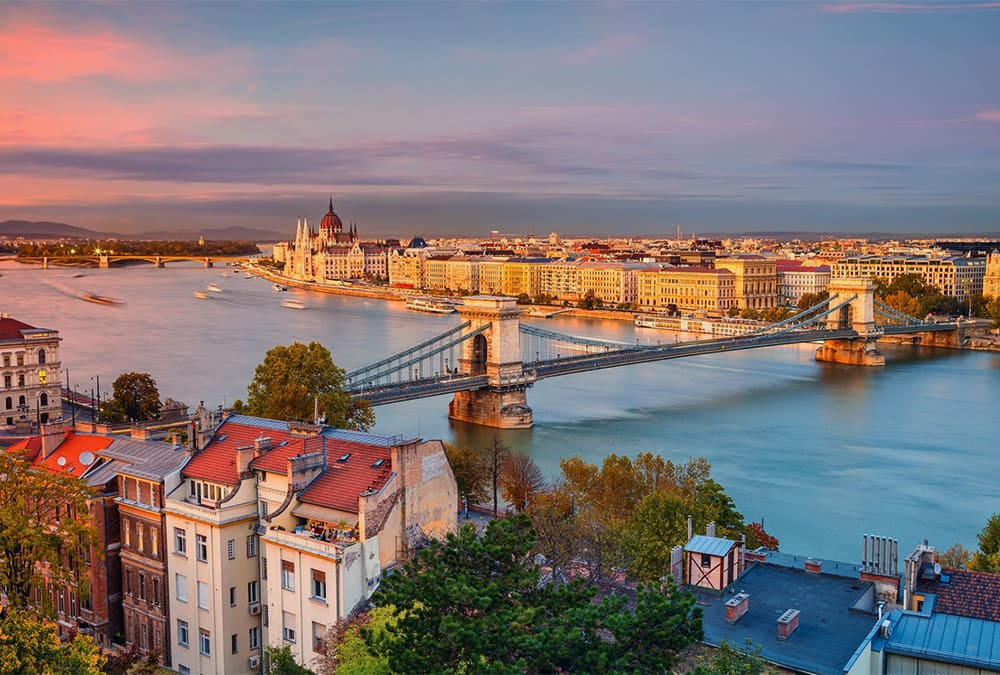

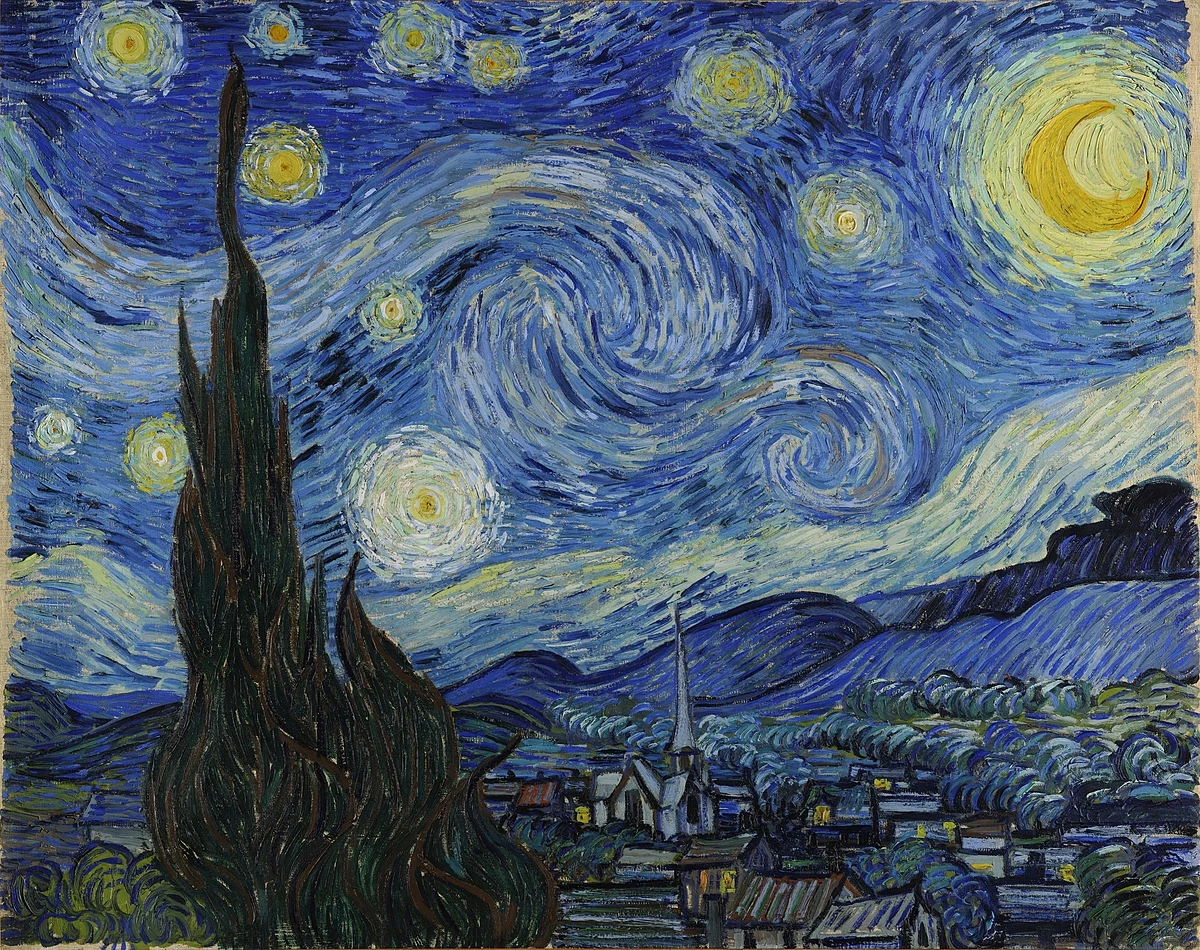

In [9]:
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)
display(Image(base_image_path, width=400))
display(Image(style_reference_image_path, width=400))


In [10]:
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    return np.clip(x, 0, 255).astype("uint8")


In [11]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    return tf.matmul(features, tf.transpose(features))
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))
def total_variation_loss(x):
    a = tf.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = tf.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))


In [12]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = {layer.name: layer.output for layer in model.layers}
feature_extractor = keras.Model(model.inputs, outputs_dict)
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(())

    # Content loss
    base_features = features[content_layer_name][0]
    combo_features = features[content_layer_name][2]
    loss += content_weight * content_loss(base_features, combo_features)

    # Style loss
    for layer_name in style_layer_names:
        style_features = features[layer_name][1]
        combo_features = features[layer_name][2]
        loss += (style_weight / len(style_layer_names)) * style_loss(
            style_features, combo_features
        )

    # Total variation
    loss += total_variation_weight * total_variation_loss(combination_image)

    return loss


In [14]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [15]:
optimizer = keras.optimizers.SGD(
    ExponentialDecay(
        initial_learning_rate=100.0,
        decay_steps=100,
        decay_rate=0.96,
    )
)


In [18]:
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0,
        decay_steps=100,
        decay_rate=0.96,
    )
)

iterations = 500

from tqdm import trange

for i in trange(1, iterations + 1, desc="Neural Style Transfer"):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 100 == 0:
        img = deprocess_image(combination_image.numpy())
        fname = f"{result_prefix}_{i}.png"
        keras.utils.save_img(fname, img)


Neural Style Transfer: 100%|██████████| 500/500 [3:30:43<00:00, 25.29s/it]


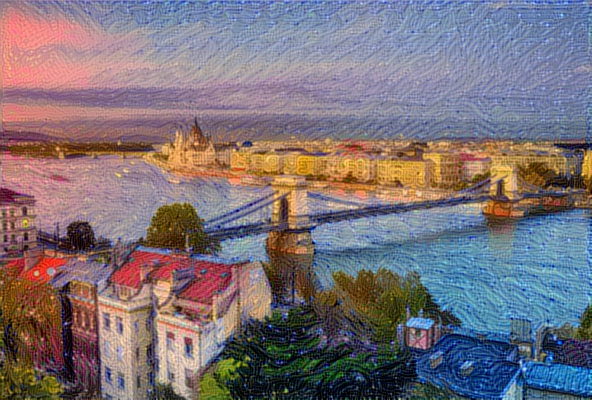

In [19]:
display(Image(f"{result_prefix}_500.png", width=500))
